# Direct analysis comparing axion signal with CMS data

In [1]:
import hist
import numpy as np
import scipy as sp
import pylhe
from mt2 import mt2
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import uncertainties.unumpy as unp
from uncertainties import ufloat
from scipy.optimize import fsolve
import csv 
from scipy.stats import poisson

In [2]:
import seaborn as sns
colors = sns.color_palette("colorblind", 8)

In [3]:
font = {'size'   : 14}
mpl.rc('font', **font)

In [4]:
lumi = 137*1e3 #fb

## General functions

In [5]:
def read_sigma_nevents(dirname):
    filename = dirname + dirname.split('/')[-2]+'_tag_1_banner.txt'
    with open(filename,'r') as f:
        data = f.readlines()
    f.close()
    sigma = float(data[-4].split(' ')[-1])
    nevents = float(data[-5].split(' ')[-1])
    return sigma, nevents

In [6]:
def csv_reader(filename):
    output = []
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            output.append(row)
        csvfile.close()

    return output

In [7]:
def read_HEPdata():
    data = csv_reader('./data/HEPData-ins1893826-v1-Figure_3d.csv')
    cms_data  = []
    cms_data_err_up = []
    cms_data_err_down = []
    
    for item in data[140:165]:
        cms_data.append(float(item[1]))
        cms_data_err_up.append(float(item[2]))
        cms_data_err_down.append(abs(float(item[3])))
    
    cms_data_err = (cms_data_err_up, cms_data_err_down)
    return cms_data, cms_data_err

In [8]:
def read_HEP_SM():
    data = csv_reader('./data/HEPData-ins1893826-v1-Figure_3d.csv')
    cms_sm  = []
    cms_sm_err = []
    
    for item in data[32:57]:
        cms_sm.append(float(item[1]))
        cms_sm_err.append(float(item[2]))
    
    return cms_sm, cms_sm_err

In [9]:
def read_HEP_SM_ttbar():
    data = csv_reader('./data/HEPData-ins1893826-v1-Figure_3d.csv')
    cms_sm_ttbar  = []
    
    for item in data[59:84]:
        cms_sm_ttbar.append(float(item[1]))
    
    return cms_sm_ttbar

In [10]:
def read_HEP_bins():
    data = data = csv_reader('./data/HEPData-ins1893826-v1-Figure_3d.csv')
    cms_bins = []
    
    for item in data[32:57]:
        cms_bins.append(float(item[0]))
    
    return cms_bins

In [11]:
def calculate_binheight(hist):
    numbins = len(cms_bins)-1
    binheight = np.zeros(numbins)
    for i in range(numbins):
        binheight[i] = hist[i]
    
    return binheight

In [12]:
def ptmiss_ttbar(arr):
    
    vecL1 = arr.particles.vector[:,-5]   
    vecL2 = arr.particles.vector[:,-2] 

    vecB1 = arr.particles.vector[:,-6]   
    vecB2 = arr.particles.vector[:,-3] 
        
    vecNu1 = arr.particles.vector[:,-4]   
    vecNu2 = arr.particles.vector[:,-1]

    vecMiss = vecNu1 + vecNu2
    ptmiss = np.sqrt((vecMiss.px)**2 + (vecMiss.py)**2)
    
    # alternative calculation, leads to the same result
    #vecMiss = -(vecL1 + vecL2 + vecB1 + vecB2)

    return ptmiss

In [13]:
def ptmiss_ttbarax(arr):
    
    vecL1 = arr.particles.vector[:,-6]   
    vecL2 = arr.particles.vector[:,-3] 

    vecB1 = arr.particles.vector[:,-7]   
    vecB2 = arr.particles.vector[:,-4] 
        
    vecNu1 = arr.particles.vector[:,-5]   
    vecNu2 = arr.particles.vector[:,-2]
    
    vecAx = arr.particles.vector[:,-1]

    vecMiss = vecNu1 + vecNu2 + vecAx
    ptmiss = np.sqrt((vecMiss.px)**2 + (vecMiss.py)**2)
    
    # alternative calculation, leads to the same result
    #vecMiss = -(vecL1 + vecL2 + vecB1 + vecB2)

    return ptmiss

In [14]:
def calculate_ptmiss(dirname):
    
    sigma, nevents = read_sigma_nevents(dirname)
    ww = sigma*lumi/nevents
    
    pylhe.register_awkward()
    filename = dirname + 'unweighted_events.lhe.gz'
    arr = pylhe.to_awkward(pylhe.read_lhe_with_attributes(filename))
    val = ptmiss_ttbar(arr)
    
    return (val, ww)

In [15]:
def calculate_ptmiss_ax(dirname):
    
    sigma, nevents = read_sigma_nevents(dirname)
    ww = sigma*lumi/nevents
    
    pylhe.register_awkward()
    filename = dirname + 'unweighted_events.lhe.gz'
    arr = pylhe.to_awkward(pylhe.read_lhe_with_attributes(filename))
    val = ptmiss_ttbarax(arr)
    
    return (val, ww)

In [16]:
def mt2_ttbar(arr):
    
    vecL1 = arr.particles.vector[:,-5]   
    vecL2 = arr.particles.vector[:,-2] 
        
    vecB1 = arr.particles.vector[:,-6]   
    vecB2 = arr.particles.vector[:,-3]
        
    massL1 = 0.1 # assume masses for the leptons
    massL2 = 0.1

    pxL1 = vecL1.px
    pyL1 = vecL1.py

    pxL2 = vecL2.px
    pyL2 = vecL2.py
    
    vecMiss = -(vecL1 + vecL2 + vecB1 + vecB2)

    pmiss_x = vecMiss.px
    pmiss_y = vecMiss.py

    mmiss1 = 0 # masses of thloc='upper right', bbox_to_anchor=(0.5, 0.5)e neutrinos or other invisible components, set to zero
    mmiss2 = 0
    
    val = mt2(
    massL1, pxL1, pyL1,  # Visible 1: mass, px, py
    massL2, pxL2, pyL2,  # Visible 2: mass, px, py
    pmiss_x, pmiss_y,  # Missing transverse momentum: x, y
    mmiss1, mmiss2)  # Invisible 1 mass, invisible 2 mass

    return val

In [17]:
def calculate_mt2(dirname):
    
    pylhe.register_awkward()
    filename = dirname + 'unweighted_events.lhe.gz'
    arr = pylhe.to_awkward(pylhe.read_lhe_with_attributes(filename))
    mt2 = mt2_ttbar(arr)
    val = (mt2>80)
    
    return (mt2, val)

## Experimental data and CMS background simulation

In [18]:
cms_data, cms_data_error = read_HEPdata()

In [19]:
cms_sm, cms_sm_error = read_HEP_SM()

In [20]:
cms_sm_ttbar = read_HEP_SM_ttbar()

In [21]:
cms_bins = read_HEP_bins()

In [22]:
print(cms_bins)

[55.0, 65.0, 75.0, 85.0, 95.0, 105.0, 115.0, 125.0, 135.0, 145.0, 155.0, 165.0, 175.0, 185.0, 195.0, 205.0, 215.0, 225.0, 235.0, 245.0, 255.0, 265.0, 275.0, 285.0, 295.0]


## SM background simulation and K- factor

In [23]:
# new run with same cuts but 100 000 events for better statistics
dir_ttbar_sm_7 = os.path.expanduser('~/Documents/MadGraph/ppttleptonic_cms/Events/run_07/')

In [24]:
sigma_7, nevents_7 = read_sigma_nevents(dir_ttbar_sm_7)

In [25]:
ptmiss_7, ww_7 = calculate_ptmiss(dir_ttbar_sm_7)

/var/folders/d0/vjgg68h93_q2fcyzx7cftx_h0000gn/T/ipykernel_37497/1269421786.py:6: DeprecationWarning: pylhe.awkward.register_awkward is deprecated as of pylhe v0.6.0 and will be removed in pylhe v0.8.0. Please remove use of pylhe.awkward.register_awkward in favor of automatic registration.
  pylhe.register_awkward()


In [26]:
mt2_7, val_7 = calculate_mt2(dir_ttbar_sm_7)

/var/folders/d0/vjgg68h93_q2fcyzx7cftx_h0000gn/T/ipykernel_37497/3507254308.py:3: DeprecationWarning: pylhe.awkward.register_awkward is deprecated as of pylhe v0.6.0 and will be removed in pylhe v0.8.0. Please remove use of pylhe.awkward.register_awkward in favor of automatic registration.
  pylhe.register_awkward()


In [27]:
ptmiss_7_mt2cut = ptmiss_7[val_7]

In [28]:
print(sigma_7, nevents_7, ww_7)

0.5866330000000001 100000.0 0.8036872100000001


In [29]:
# histogram with normalisation for the correct binheight
axis_sm_7 = hist.axis.Variable(cms_bins, name="ptmiss");
hist_sm_7 = hist.Hist(axis_sm_7);
hist_sm_7.fill(ptmiss=ptmiss_7_mt2cut, weight=ww_7);

In [30]:
width = 0.05
binspacing = (cms_bins[1]-cms_bins[0])/2
numbins = len(cms_bins) -1 

In [31]:
# get the binheight from the distributions normalised with the total cross section
# get the Nbin from the distribution with no normalisation

bincenters = np.zeros(numbins)
binheight_sm = np.zeros(numbins)
Nbin_sm = np.zeros(numbins)
y_err_sm = np.zeros(numbins)
    
for i in range(numbins):
    bincenters[i] = cms_bins[i]+binspacing
    binheight_sm[i] = hist_sm_7[i]

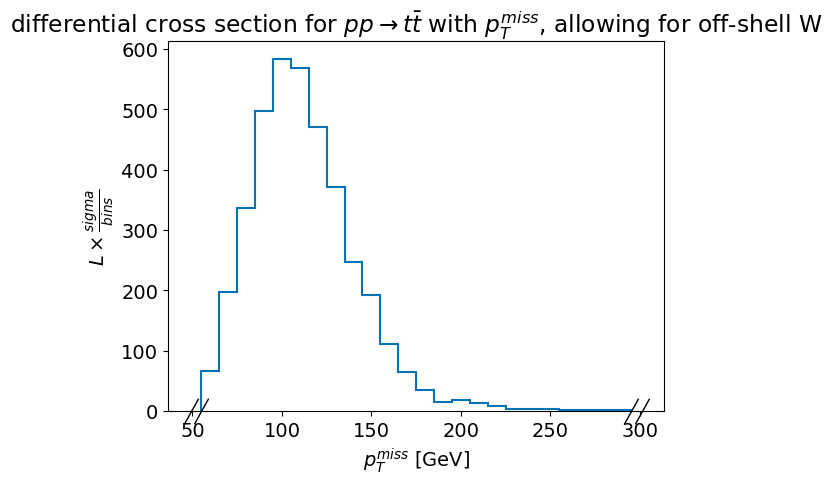

In [32]:
artists = hist_sm_7.plot1d(color = colors[0]);
#artists1 = hist_sm_8.plot1d(color = colors[1]);

ax = artists[0].stairs.axes;
#ax.set_yscale("log");
ax.set_xlabel("$p_T^{miss}$ [GeV]");
ax.set_ylabel(r"$L \times \frac{sigma}{bins}$");
ax.set_title(r'differential cross section for $ p p \rightarrow t \bar{t}$ with $p_T^{miss}$, allowing for off-shell W');
plt.bar(bincenters, binheight_sm, width=width, color='none', yerr=y_err_sm, log = False)
plt.rc('axes', labelsize=20)
#plt.savefig("./plots/ttbar_sm_cms.png")

In [33]:
binheight_mg_sm = unp.uarray(binheight_sm, y_err_sm)

In [34]:
binheight_sm_cms = unp.uarray(cms_sm, cms_sm_error)

In [35]:
binheight_sm_ttbar_cms = cms_sm_ttbar

In [36]:
Kfactor_cms = binheight_sm_cms[:10]/binheight_mg_sm[:10]

In [37]:
Kfactor_cms_ttbar = binheight_sm_ttbar_cms[:10]/binheight_mg_sm[:10]

In [38]:
print(Kfactor_cms)

[22.486719872805374+/-1.0913104977204084
 16.269525747582282+/-0.5273964589008284
 15.422948848856523+/-0.3652913081288202
 13.723157562246273+/-0.26604724769296106
 13.496335167412605+/-0.23587908379781033
 14.143792695117568+/-0.2351432374380532
 15.935314619487864+/-0.2722069333033538
 17.155003648046552+/-0.305933361838117
 20.745588534849457+/-0.4099590279177944
 20.327663710529052+/-0.45132089800624486]


In [39]:
print(Kfactor_cms_ttbar)

[16.388321443300555+/-0 13.42390142824205+/-0 13.526855033392318+/-0
 12.383659803126195+/-0 12.331250511699814+/-0 13.064960238343923+/-0
 14.773787769378773+/-0 16.012322117358156+/-0 19.380544534822633+/-0
 18.9988922016896+/-0]


In [40]:
# define the nominal value of the first bin as "the K-factor"
kfactor = unp.nominal_values(Kfactor_cms)[0]

In [41]:
kfactor

22.486719872805374

Text(0.5, 1.0, 'K-factor for LO SM MG simulation for $pp \\rightarrow t\\bar{t}$ versus CMS prediction')

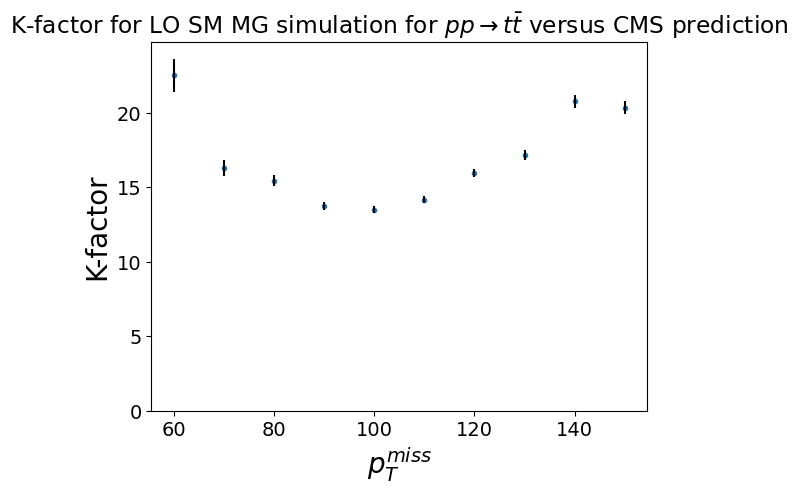

In [42]:
plt.figure()
plt.plot(bincenters[:10], unp.nominal_values(Kfactor_cms), '.')
plt.xlabel(r"$p_T^{miss}$")
plt.ylabel("K-factor")
plt.bar(bincenters[:10], unp.nominal_values(Kfactor_cms), width=width, color='none', yerr=unp.std_devs(Kfactor_cms), log = False)
plt.title(r"K-factor for LO SM MG simulation for $pp \rightarrow t\bar{t}$ versus CMS prediction")
#plt.savefig("./plots/kfactor_cms.pdf", bbox_inches="tight")

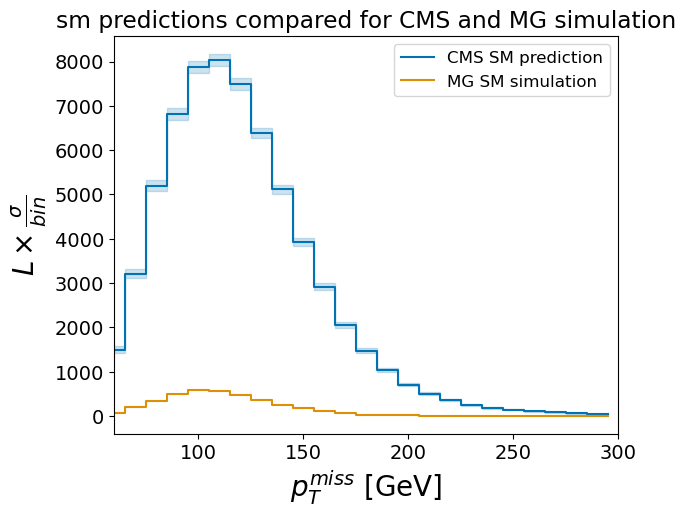

In [43]:
# plots

cms_sm_plot = np.array(cms_sm)
cms_sm_plot_error = np.array(cms_sm_error)
binheight_sm_plot = np.concatenate([binheight_sm, [binheight_sm[-1]]])
#print(binheight_sm_plot[0])
#binheight_sm_plot*=unp.nominal_values(Kfactor_cms)[0]

#Create figure and axes
fig = plt.figure(figsize=(7, 7))
gs = fig.add_gridspec(2, 1, height_ratios=(4, 1), left=0.14, right=0.86, bottom=0.1, top=0.9, wspace=0.55, hspace=0.25)
    
ax = fig.add_subplot(gs[0, 0])
#ax_ratio = fig.add_subplot(gs[1, 0], sharex=ax)

#Plot data
ax.step(cms_bins, cms_sm_plot, where='post',label='CMS SM prediction', color=colors[0])
ax.fill_between(cms_bins, cms_sm_plot-cms_sm_plot_error, cms_sm_plot+cms_sm_plot_error, color=colors[0],step='post', alpha=0.2)
ax.set_title('sm predictions compared for CMS and MG simulation')
#ax.set_yscale('log')
ax.set_xlim([60,300]);
ax.set_xlabel(r'$p_T^{miss}$ [GeV]')
ax.set_ylabel(r'$L \times\frac{\sigma}{bin}$')

ax.step(cms_bins, binheight_sm_plot, where='post',label=r'MG SM simulation', color=colors[1])
#ax.step(cms_bins, binheight_sm_2_plot, where='post',label=r'MG SM simulation, drll = 0.4', color=colors[2])

ax.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1, 1));
#plt.tight_layout()
#plt.savefig('plots/sm_simulations_cms.pdf', bbox_inches="tight")
plt.show()

### Without fortran $m_{T,1}$ cut

In [44]:
# new run with 100 000 events and no fortran cut on m_{T,1}
dir_ttbar_sm_8 = os.path.expanduser('~/Documents/MadGraph/ppttleptonic_cms/Events/run_08/')

In [45]:
sigma_8, nevents_8 = read_sigma_nevents(dir_ttbar_sm_8)

In [46]:
ptmiss_8, ww_8 = calculate_ptmiss(dir_ttbar_sm_8)

In [47]:
mt2_8, val_8 = calculate_mt2(dir_ttbar_sm_8)

In [48]:
ptmiss_8_mt2cut = ptmiss_8[val_8]

In [49]:
print(sigma_8, nevents_8, ww_8)

8.08128 100000.0 11.071353599999998


In [50]:
# histogram with normalisation for the correct binheight
axis_sm_8 = hist.axis.Variable(cms_bins, name="ptmiss");
hist_sm_8 = hist.Hist(axis_sm_8);
hist_sm_8.fill(ptmiss=ptmiss_8_mt2cut, weight=ww_8);

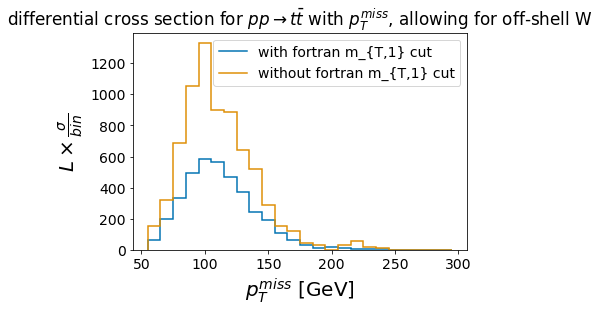

In [51]:
artists = hist_sm_7.plot1d(color = colors[0], label = "with fortran m_{T,1} cut");
artists1 = hist_sm_8.plot1d(color = colors[1], label = "without fortran m_{T,1} cut");

ax = artists[0].stairs.axes;
#ax.set_yscale("log");
ax.set_xlabel("$p_T^{miss}$ [GeV]");
ax.set_ylabel(r"$L \times \frac{\sigma}{bin}$");
ax.set_title(r'differential cross section for $ p p \rightarrow t \bar{t}$ with $p_T^{miss}$, allowing for off-shell W');
plt.bar(bincenters, binheight_sm, width=width, color='none', yerr=y_err_sm, log = False)
plt.legend()
plt.rc('axes', labelsize=20)

In [52]:
bincenters = np.zeros(numbins)
binheight_sm = np.zeros(numbins)
Nbin_sm = np.zeros(numbins)
y_err_sm = np.zeros(numbins)
    
for i in range(numbins):
    bincenters[i] = cms_bins[i]+binspacing
    binheight_sm[i] = hist_sm_8[i]

In [53]:
binheight_mg_sm = unp.uarray(binheight_sm, y_err_sm)

In [54]:
binheight_sm_cms = unp.uarray(cms_sm, cms_sm_error)

In [55]:
Kfactor_cms = binheight_sm_cms[:10]/binheight_mg_sm[:10]

In [56]:
# define the nominal value of the first bin as "the K-factor"
kfactor = unp.nominal_values(Kfactor_cms)[0]

In [57]:
kfactor

9.677484887020242

Text(0.5, 1.0, 'K-factor for LO SM MG simulation for $pp \\rightarrow t\\bar{t}$ versus CMS prediction')

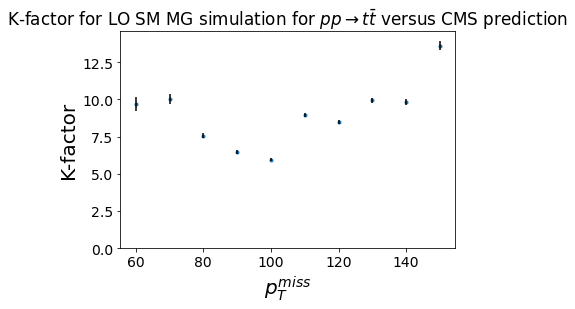

In [58]:
plt.figure()
plt.plot(bincenters[:10], unp.nominal_values(Kfactor_cms), '.')
plt.xlabel(r"$p_T^{miss}$")
plt.ylabel("K-factor")
plt.bar(bincenters[:10], unp.nominal_values(Kfactor_cms), width=width, color='none', yerr=unp.std_devs(Kfactor_cms), log = False)
plt.title(r"K-factor for LO SM MG simulation for $pp \rightarrow t\bar{t}$ versus CMS prediction")
#plt.savefig("./plots/kfactor_cms.pdf", bbox_inches="tight")

### Weaker $m_{T,2}$ cuts

In [66]:
val_70 = (mt2_8>70)

In [78]:
val_73 = (mt2_8>73)

In [82]:
val_74 = (mt2_8>74)

In [67]:
ptmiss_8_mt2cut70 = ptmiss_8[val_70]

In [79]:
ptmiss_8_mt2cut73 = ptmiss_8[val_73]

In [83]:
ptmiss_8_mt2cut74 = ptmiss_8[val_74]

In [62]:
# histogram with normalisation for the correct binheight
axis_sm_8 = hist.axis.Variable(cms_bins, name="ptmiss");
hist_sm_8 = hist.Hist(axis_sm_8);
hist_sm_8.fill(ptmiss=ptmiss_8_mt2cut, weight=ww_8);

In [68]:
# histogram with normalisation for the correct binheight
axis_sm_70 = hist.axis.Variable(cms_bins, name="ptmiss");
hist_sm_70 = hist.Hist(axis_sm_70);
hist_sm_70.fill(ptmiss=ptmiss_8_mt2cut70, weight=ww_8);

In [80]:
# histogram with normalisation for the correct binheight
axis_sm_73 = hist.axis.Variable(cms_bins, name="ptmiss");
hist_sm_73 = hist.Hist(axis_sm_73);
hist_sm_73.fill(ptmiss=ptmiss_8_mt2cut73, weight=ww_8);

In [84]:
# histogram with normalisation for the correct binheight
axis_sm_74 = hist.axis.Variable(cms_bins, name="ptmiss");
hist_sm_74 = hist.Hist(axis_sm_74);
hist_sm_74.fill(ptmiss=ptmiss_8_mt2cut74, weight=ww_8);

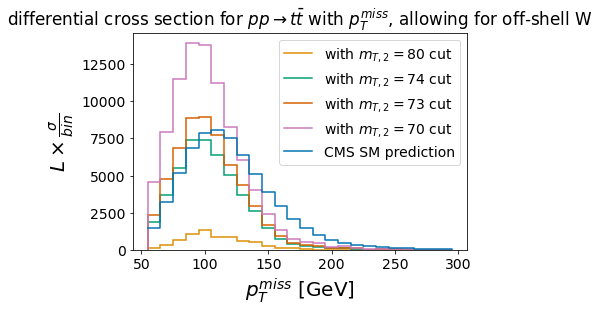

In [97]:
artists = hist_sm_8.plot1d(color = colors[1], label = "with $m_{T,2} = 80$ cut");
artists1 = hist_sm_74.plot1d(color = colors[2], label = "with $m_{T,2} = 74$ cut");
artists2 = hist_sm_73.plot1d(color = colors[3], label = "with $m_{T,2} = 73$ cut");
artists3 = hist_sm_70.plot1d(color = colors[4], label = "with $m_{T,2} = 70$ cut");
ax = artists[0].stairs.axes;
ax.step(cms_bins, cms_sm_plot, where='post',label='CMS SM prediction', color=colors[0])

#ax.set_yscale("log");
ax.set_xlabel("$p_T^{miss}$ [GeV]");
ax.set_ylabel(r"$L \times \frac{\sigma}{bin}$");
ax.set_title(r'differential cross section for $ p p \rightarrow t \bar{t}$ with $p_T^{miss}$, allowing for off-shell W');
plt.bar(bincenters, binheight_sm, width=width, color='none', yerr=y_err_sm, log = False)
plt.legend()
plt.savefig('plots/cms_mt2cuts.pdf', bbox_inches="tight")
plt.rc('axes', labelsize=20)